# Creation of a binary classifier with moons dataset

## Data creation and data split
Make a binary classification dataset with Scikit-Learn's make_moons() function. For consistency, the dataset should have 1000 samples and a random_state=42.

(1000, 2) (1000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


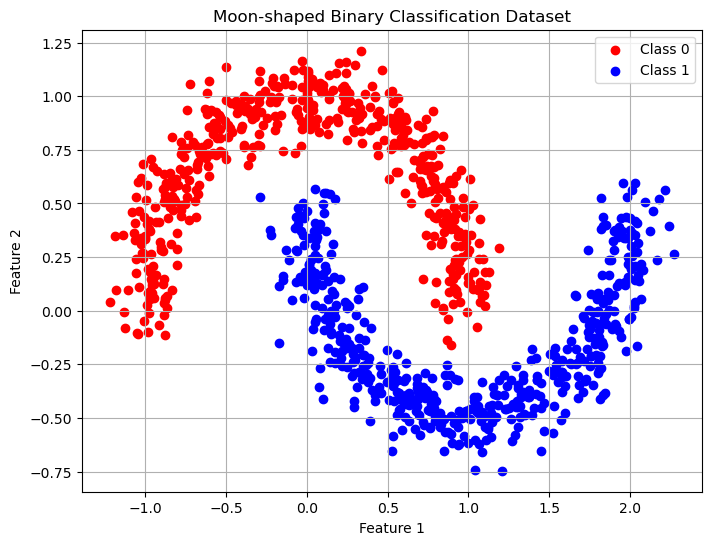

In [122]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
# Helper function to plot the moons dataset
def plot_moons(X, y):        
    # Create a scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', label='Class 0')
    plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', label='Class 1')
    
    # Add labels and title
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Moon-shaped Binary Classification Dataset')
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.show()


X, y = make_moons(
    n_samples=1000, 
    noise=0.1,
    random_state=42
)

print(X.shape, y.shape)
print(type(X), type(y))

# Call the function with your data
plot_moons(X, y)

Turn the data into PyTorch tensors. Split the data into training and test sets using train_test_split with 80% training and 20% testing.

In [123]:
X = (
    torch.from_numpy(X) # We can use torch.from_numpy() to convert a numpy array to a torch tensor
    .type(torch.float) # We need to convert the data type to float to be compatible with PyTorch    
)

y = torch.from_numpy(y).type(torch.float)

In [124]:
# let's examing the shapes of the tensors
print(f"X.shape: {X.shape}, y.shape: {y.shape}")
# Notice that the y tensor contains values 0 and 1 representing each of the two classes
y[:10]
 

X.shape: torch.Size([1000, 2]), y.shape: torch.Size([1000])


tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.])

In [125]:
# Lets split the data into training and test sets
train_split = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:train_split], X[train_split:], y[:train_split], y[train_split:]

print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")

X_train.shape: torch.Size([800, 2]), y_train.shape: torch.Size([800])
X_test.shape: torch.Size([200, 2]), y_test.shape: torch.Size([200])


# Make Device Agnostic


In [126]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Building the model
Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.

In [127]:
from torch import nn

class MoonModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Notice how we intercalate the non-linear function with the linear layers
        return self.layer_3(
            self.relu(
                self.layer_2(
                    self.relu(
                        self.layer_1(x)
                    )
                )
            )
        )

# Logits intro probabilities
Remember that the model will output a raw unnormalized scores beloging to the last layer of the neural net.

In [128]:
# Make some predictions with the untrained model
model_v0 = MoonModelV0()
y_preds = model_v0(X_test)
print(f"shape of predictions: {y_preds.shape}")
print(y_preds[:10])

shape of predictions: torch.Size([200, 1])
tensor([[ 0.0174],
        [ 0.0265],
        [ 0.0157],
        [-0.0028],
        [ 0.0227],
        [ 0.0184],
        [ 0.0314],
        [ 0.0282],
        [ 0.0162],
        [ 0.0281]], grad_fn=<SliceBackward0>)


 We need to convert them to probabilities. In our case, we will use the sigmoid function so we can get a value between 0 and 1.

In [129]:
y_probabilities = torch.sigmoid(y_preds)
print(f"shape of probabilities: {y_probabilities.shape}")    
print(y_probabilities[:10])
print(f"min: {y_probabilities.min()}, max: {y_probabilities.max()}")

shape of probabilities: torch.Size([200, 1])
tensor([[0.5043],
        [0.5066],
        [0.5039],
        [0.4993],
        [0.5057],
        [0.5046],
        [0.5079],
        [0.5070],
        [0.5041],
        [0.5070]], grad_fn=<SliceBackward0>)
min: 0.4972536861896515, max: 0.5104178190231323


Lets create a visualization to help us get an idea of the model performance..
This visualization is particularly useful because it shows:
- The decision boundary (where probability = 0.5)
- The model's confidence in different regions
- How well the model separates the two classes


Example probability values and their colors:
0.0 -> Deep Red    (Very confident it's Class 0)
0.3 -> Light Red   (Somewhat confident it's Class 0)
0.5 -> White      (Decision boundary - Uncertain)
0.7 -> Light Blue  (Somewhat confident it's Class 1)
1.0 -> Deep Blue   (Very confident it's Class 1)


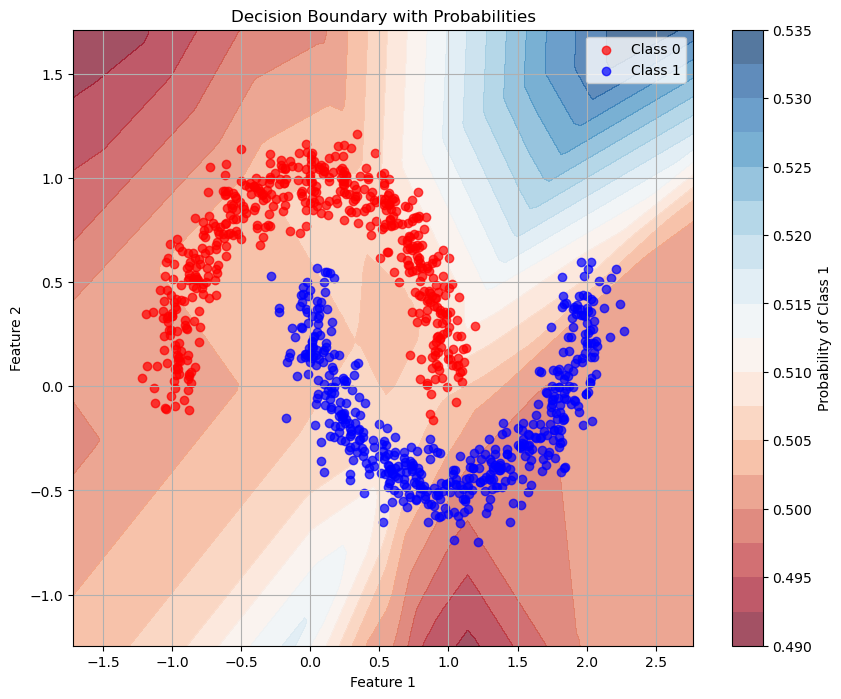

In [130]:
def plot_decision_boundary(X, y, model):
    # Create a new figure with specified size
    plt.figure(figsize=(10, 8))
    
    # Find the boundaries of our plot
    # We add 0.5 to each side to have some padding around the data points
    # `X[:, 0]` gets the first column of X, which contains the first feature
    # `X[:, 1]` gets the second column of X, which contains the second feature
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5  # Boundaries for first feature
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5  # Boundaries for second feature
    
    # Create a grid of points that covers our data space
    # torch.linspace creates 100 evenly spaced points between min and max
    # meshgrid creates a 2D grid from these points (100x100 grid)
    xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, 100),
                           torch.linspace(y_min, y_max, 100))
    
    # Prepare the grid points for model prediction:
    # 1. Flatten the grids and stack them to create pairs of (x,y) coordinates
    # 2. Shape becomes (10000, 2) where each row is a point to predict
    grid = torch.stack([xx.flatten(), yy.flatten()], dim=1)
    
    # Make predictions for all points in our grid
    with torch.no_grad():  # We don't need gradients for prediction
        logits = model(grid)  # Get raw model outputs
        probabilities = torch.sigmoid(logits)  # Convert to probabilities (0 to 1)
    
    # Reshape the predictions back to match our grid (100x100)
    probabilities = probabilities.reshape(xx.shape)
    
        # Print some example probabilities and their corresponding colors
    print("Example probability values and their colors:")
    print("0.0 -> Deep Red    (Very confident it's Class 0)")
    print("0.3 -> Light Red   (Somewhat confident it's Class 0)")
    print("0.5 -> White      (Decision boundary - Uncertain)")
    print("0.7 -> Light Blue  (Somewhat confident it's Class 1)")
    print("1.0 -> Deep Blue   (Very confident it's Class 1)")
    
    # Create the contour plot:
    # - xx and yy define the grid points
    # - probabilities defines the color at each point
    # - levels=20 creates 20 different color bands
    # - cmap='RdBu' uses a red-blue colormap (red for 0, blue for 1)
    plt.contourf(xx, yy, probabilities, levels=20, cmap='RdBu', alpha=0.7)
    
    # Add a colorbar to show the mapping between colors and probabilities
    plt.colorbar(label='Probability of Class 1')
    
    # Plot the original data points on top of the contour
    # Alpha makes the points slightly transparent
    plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', label='Class 0', alpha=0.7)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', label='Class 1', alpha=0.7)
    
    # Add labels and make the plot pretty
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary with Probabilities')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function with your model and data
plot_decision_boundary(X, y, model_v0)

## Set loss, Optimizer, Accuracy functions
Setup a binary classification compatible loss function and optimizer to use when training the model.


In [131]:
# This loss function has a sigmoid layer (nn.Sigmoid) built-in
# loss_fn = nn.BCEWithLogitsLoss()

loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(params=model_v0.parameters(), lr=0.1)

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

# Build training loop

In [132]:
# Set the random state
torch.manual_seed(42)

# Lets put data into our device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
# Set number of epochs
epochs = 2000

for epoch in range(epochs):
    
    #===== TRAINING ======
    # Set the model in training mode
    model_v0.train()
    # 1. Forward step
    y_logits = model_v0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(
        torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
        y_train
    )    
    acc = accuracy_fn(y_train, y_pred)

    # 3. Set optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss Backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    #===== TESTING =======
    # ----> Change the model to evaluation mode
    model_v0.eval()

    # ----> Perform the tests using the context manager to set torch in inference mode
    with torch.inference_mode():
        # 1.forward pass
        test_logits = model_v0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Calculate the loss and accuracy
        test_loss = loss_fn(test_pred, y_test)
        test_acc = accuracy_fn(y_test, test_pred)
        # print out every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")




Epoch: 0 | Loss: 0.69528, Accuracy: 39.12% | Test loss: 53.00000, Test acc: 47.00%
Epoch: 10 | Loss: 0.68189, Accuracy: 72.88% | Test loss: 24.50000, Test acc: 75.50%
Epoch: 20 | Loss: 0.66771, Accuracy: 79.12% | Test loss: 21.50000, Test acc: 78.50%
Epoch: 30 | Loss: 0.65063, Accuracy: 78.00% | Test loss: 25.00000, Test acc: 75.00%
Epoch: 40 | Loss: 0.62627, Accuracy: 74.88% | Test loss: 27.00000, Test acc: 73.00%
Epoch: 50 | Loss: 0.59392, Accuracy: 74.62% | Test loss: 26.50000, Test acc: 73.50%
Epoch: 60 | Loss: 0.55442, Accuracy: 75.38% | Test loss: 25.00000, Test acc: 75.00%
Epoch: 70 | Loss: 0.50982, Accuracy: 76.12% | Test loss: 24.00000, Test acc: 76.00%
Epoch: 80 | Loss: 0.46453, Accuracy: 77.75% | Test loss: 22.50000, Test acc: 77.50%
Epoch: 90 | Loss: 0.42381, Accuracy: 78.88% | Test loss: 20.00000, Test acc: 80.00%
Epoch: 100 | Loss: 0.38996, Accuracy: 80.62% | Test loss: 19.50000, Test acc: 80.50%
Epoch: 110 | Loss: 0.36254, Accuracy: 83.25% | Test loss: 19.00000, Test acc

Example probability values and their colors:
0.0 -> Deep Red    (Very confident it's Class 0)
0.3 -> Light Red   (Somewhat confident it's Class 0)
0.5 -> White      (Decision boundary - Uncertain)
0.7 -> Light Blue  (Somewhat confident it's Class 1)
1.0 -> Deep Blue   (Very confident it's Class 1)


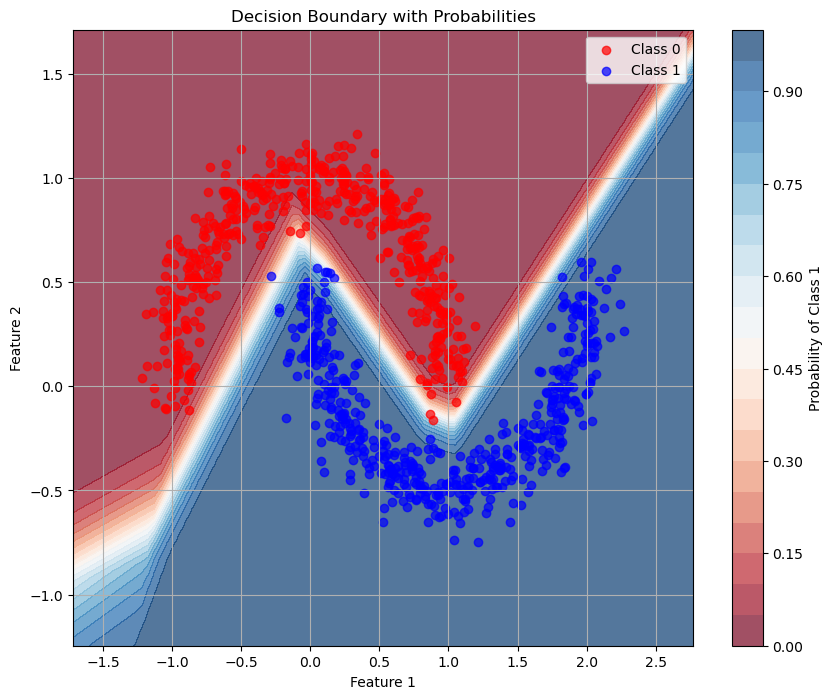

In [133]:
# Call the function with your model and data
plot_decision_boundary(X, y, model_v0)